# Evaluation of GPU memory consumption for CUDA Tensors

In [1]:
import sys
sys.path.append("/Users/danielherbst/Desktop/evaluation")

In [2]:
from evaluation_routines.data_loading import OCPDataFrameLoader
from evaluation_routines.cuda_memory import CUDAMemory
from evaluation_routines.runtimes import Runtimes

## Data loading

At first, we specify the paths necessary for evaluation. This includes:
- the ocp metrics directory stored in `ocp_metrics_path`
- the directory `directory` for the specific model/series of runs we would like to consider
- the runs `runs` as a `dict` with shorter name as key and the respective csv filenames without "_resources/..." extensions

In [3]:
ocp_metrics_path = "/Users/danielherbst/Desktop/ocp-metrics"
directory = "s2ef/gemnet_xl/batch_size_2"

runs = {
    "S0":           "1658821209_stage0_8gpus",
    "S0+fp16":      "1658836096_stage0_8gpus_fp16",
    "S1":           "1658796065_stage1_8gpus",
    "S1+OC":        "1658874784_stage1_8gpus",
    "S2+OC":        "1658848228_stage2_8gpus",
    "S2+OO+OC":     "1658859227_stage2_8gpus_offloadOptimizer[cpu]",
    "S3+OC":        "1658884621_stage3_8gpus",
    "S3+PO+OO+OC":  "1658898067_stage3_8gpus_offloadOptimizer[cpu]_offloadParam[cpu]"
}
formatted_run_names_1 = [
    r"\textbf{S0}",
    r"\textbf{S0}" + "+fp16",
    r"\textbf{S1}",
    r"\textbf{S1}" + "+OC",
    r"\textbf{S2}" + "+OC",
    r"\textbf{S2}" + "+OO+OC",
    r"\textbf{S3}" + "+OC",
    r"\textbf{S3}" + "+PO+OO+OC"
]
formatted_run_names_2 = [
    r"\textbf{S0}",
    r"\textbf{S0}" + "+fp16",
    r"\textbf{S1}",
    r"\textbf{S1}" + "+OC",
    r"\textbf{S2}" + "+OC",
    r"\textbf{S2}" + "+OO\n+OC",
    r"\textbf{S3}" + "+OC",
    r"\textbf{S3}" + "+PO\n+OO+OC"
]

data_loader = OCPDataFrameLoader(ocp_metrics_path, directory, runs)
cuda_memory, runtimes = CUDAMemory(data_loader), Runtimes(data_loader)

In [4]:
resources_paths, torch_cuda_paths, runtimes_paths = data_loader.get_paths()

## Inspection of a single run

At first, we inspect single runs with a set DeepSpeed configuration. We look at statistical summaries of the allocated and reserved memory as well as runtimes.

In [5]:
cuda_df = data_loader.get_metrics_csv(torch_cuda_paths["S0"], csv_type="torch_cuda")
cuda_df

,datetime,epoch,rank,gpu_memory_allocated,gpu_memory_reserved
0,2022-07-26 07:40:11.698359,0,0,2367.652864,2562.719744
1,2022-07-26 07:40:11.699225,0,1,2367.652864,2562.719744
2,2022-07-26 07:40:11.700212,0,2,2367.652864,2562.719744
3,2022-07-26 07:40:11.700135,0,7,2367.652864,2562.719744
4,2022-07-26 07:40:11.699473,0,6,2367.652864,2562.719744
...,...,...,...,...,...
199995,2022-07-26 11:47:09.023206,0,5,7142.172160,42440.065024
199996,2022-07-26 11:47:09.023281,0,2,7092.075520,31929.139200
199997,2022-07-26 11:47:09.023545,0,4,7103.862272,43186.651136
199998,2022-07-26 11:47:09.023682,0,3,7103.119360,38767.951872


In [6]:
runtimes_df = data_loader.get_metrics_csv(runtimes_paths["S0"], csv_type="runtimes")
runtimes_df

,rank,epoch,epoch_time,dataloading_time,forward_time,backward_time,rest
0,0,0,14820.271637,21.439089,1940.971650,11508.325882,1349.535015
1,2,0,14820.308644,53.219034,2058.297934,11489.151467,1219.640208
2,1,0,14820.313890,62.580859,2012.285479,11484.891519,1260.556033
3,7,0,14820.314157,67.700463,2222.304426,11479.410375,1050.898894
4,3,0,14820.326572,47.820038,2120.407255,11498.230845,1153.868434
5,6,0,14820.329401,60.376123,2174.625988,11486.901609,1098.425680
6,4,0,14820.333727,49.368530,2425.570624,11495.666023,849.728549
7,5,0,14820.338463,51.768961,2196.365318,11487.539760,1084.664424


In [7]:
runtimes.means("S0")

epoch_time          04:07:00
dataloading_time    00:00:51
forward_time        00:35:43
backward_time       03:11:31
rest                00:18:53
dtype: object

In [8]:
cuda_memory.summary_per_gpu("S0")

gpu_memory_allocated                                                    \
                    count         mean        std          min          25%   
rank                                                                          
0                 25000.0  7105.915426  29.968638  2367.652864  7106.072064   
1                 25000.0  7095.922161  29.905436  2367.652864  7096.076288   
2                 25000.0  7091.805703  29.879399  2367.652864  7091.960832   
3                 25000.0  7102.993205  29.950163  2367.652864  7103.145472   
4                 25000.0  7103.675156  29.954507  2367.652864  7103.816704   
5                 25000.0  7141.955368  30.196596  2367.652864  7142.108160   
6                 25000.0  7111.461883  30.003724  2367.652864  7111.616000   
7                 25000.0  7116.190711  30.033638  2367.652864  7116.342272   

                                            gpu_memory_reserved                \
              50%          75%          max               count          mean   
rank                                                                            
0     7106.104320  7106.137088  7106.310144             25000.0  36599.870249   
1     7096.110592  7096.144896  7096.308736             25000.0  37944.071364   
2     7091.993088  7092.027392  7092.166656             25000.0  30868.330848   
3     7103.184384  7103.217664  7103.397376             25000.0  36325.355317   
4     7103.859712  7103.906304  7104.090624             25000.0  42139.615536   
5     7142.144000  7142.181888  7142.385152             25000.0  37945.334185   
6     7111.651328  7111.686784  7111.860736             25000.0  43228.769582   
7     7116.380672  7116.417024  7116.589056             25000.0  36632.327115   

                                                                          \
              std          min           25%           50%           75%   
rank                                                                       
0     3297.506880  2562.719744  33619.443712  38587.596800  38587.596800   
1     2277.630726  2562.719744  38791.020544  38791.020544  38791.020544   
2     1437.031741  2562.719744  29288.824832  31929.139200  31929.139200   
3     2892.795111  2562.719744  35777.413120  35777.413120  38767.951872   
4     1969.011986  2562.719744  39875.248128  43186.651136  43186.651136   
5     2797.255577  2562.719744  36064.722944  39246.102528  39246.102528   
6     3274.584182  2562.719744  41584.427008  44570.771456  44570.771456   
7     1443.623741  2562.719744  37163.630592  37163.630592  37163.630592   

                    
               max  
rank                
0     38587.596800  
1     38791.020544  
2     31929.139200  
3     38767.951872  
4     43186.651136  
5     42440.065024  
6     44570.771456  
7     37163.630592

In [9]:
cuda_memory.summary_averaged("S0")

,gpu_memory_allocated,gpu_memory_reserved
count,200000.000000,200000.000000
mean,7108.739952,37710.459275
std,33.311518,4363.337636
min,2367.652864,2562.719744
25%,7096.283904,35777.413120
50%,7104.087040,38587.596800
75%,7111.840128,39873.150976
max,7142.385152,44570.771456


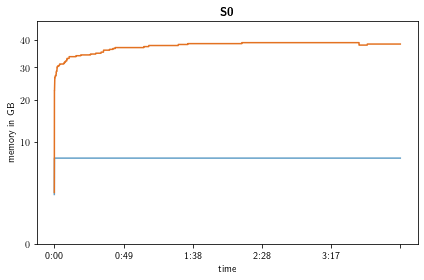

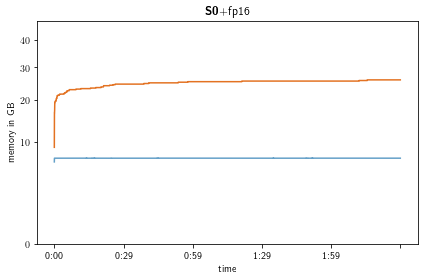

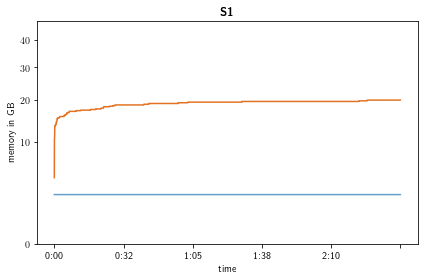

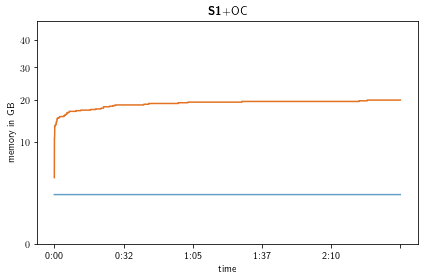

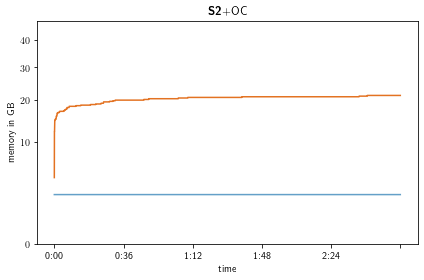

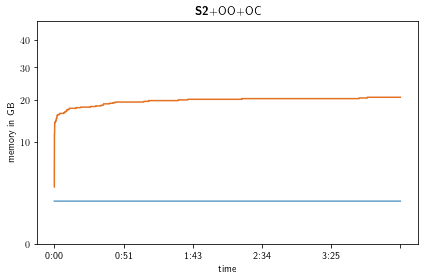

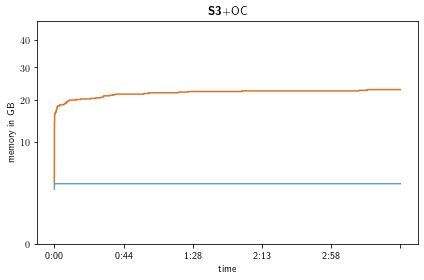

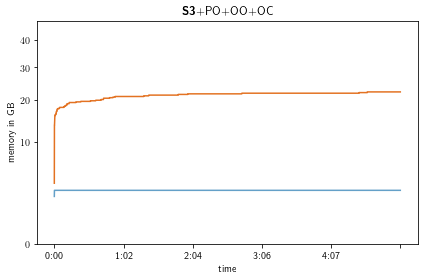

In [10]:
for i, run in enumerate(runs):
    cuda_memory.plot_cuda_memory(
        run, 
        mode="averaged", 
        title=formatted_run_names_1[i],
        save=True, 
        save_dir="../outputs/gemnet/s2ef/cuda_memory"
    )

For a single run, the GPU CUDA torch memory consumption can be plotted versus time, individually on each GPU or averaged/summed across all involved GPUs.

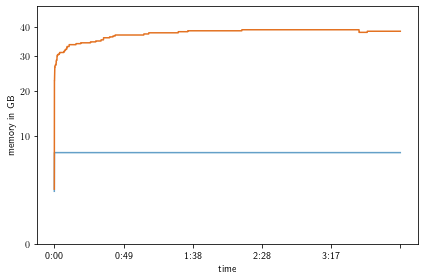

In [11]:
cuda_memory.plot_cuda_memory("S0", mode="averaged")

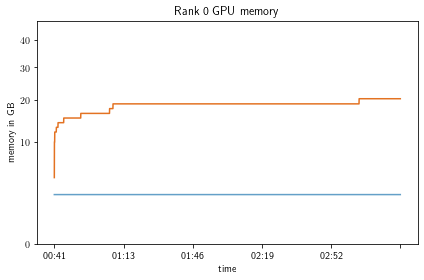

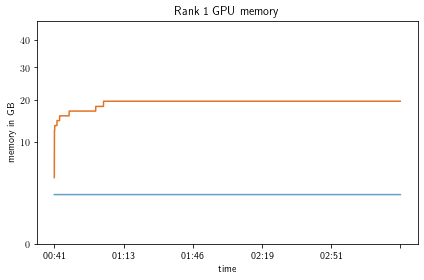

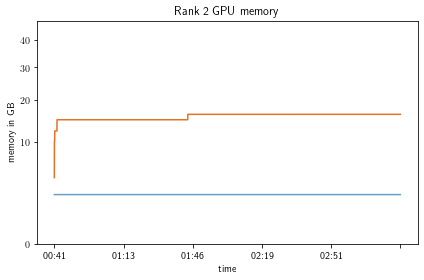

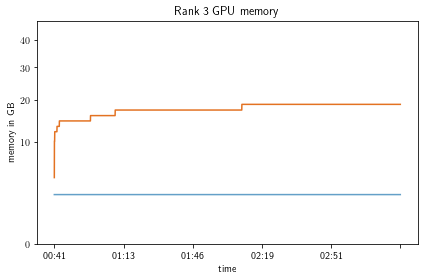

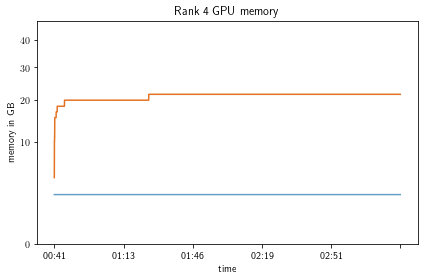

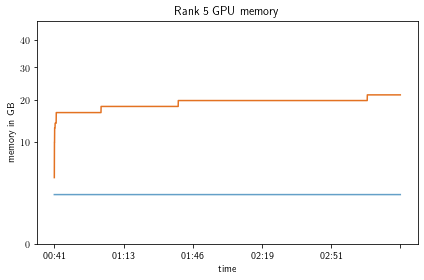

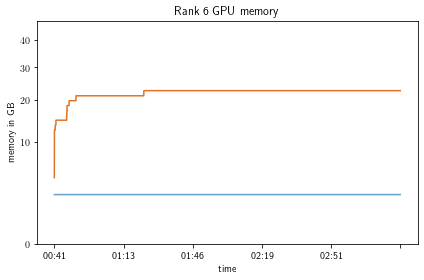

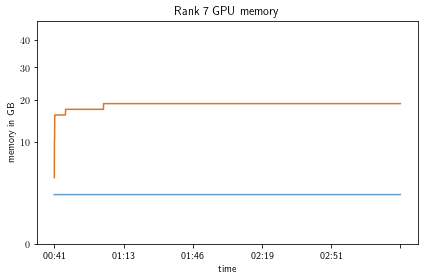

In [12]:
cuda_memory.plot_cuda_memory("S1", mode="individual")

## Comparison of memory and runtimes for different runs

For different runs, the allocated and reserved GPU CUDA memory as well as the runtimes can be compared.

In [13]:
runtimes.compare(save=True, save_dir="../outputs/gemnet/s2ef/runtimes")

,S0,S0+fp16,S1,S1+OC,S2+OC,S2+OO+OC,S3+OC,S3+PO+OO+OC
epoch_time,04:07:00,02:29:03,02:43:45,02:42:51,03:00:41,04:18:11,03:43:01,05:09:53
dataloading_time,00:00:51,00:00:45,00:00:29,00:00:26,00:00:30,00:00:29,00:00:27,00:00:24
forward_time,00:35:43,00:21:36,00:21:59,00:21:57,00:21:58,00:21:57,00:54:57,00:54:32
backward_time,03:11:31,01:53:35,01:39:38,01:38:45,01:56:29,03:09:20,02:05:26,03:52:43
rest,00:18:53,00:13:05,00:41:39,00:41:41,00:41:43,00:46:23,00:42:11,00:22:13


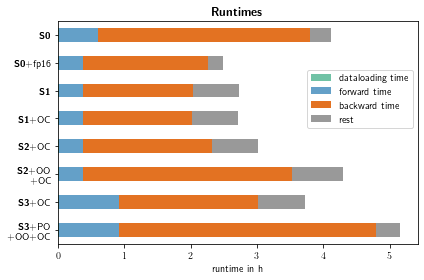

In [14]:
runtimes.compare_plot(
    yticks=formatted_run_names_2, 
    figsize=(6, 4), 
    title=r"\textbf{Runtimes}",
    save=True,
    save_dir="../outputs/gemnet/s2ef/runtimes"
)

In [15]:
cuda_memory.compare(save=True, save_dir="../outputs/gemnet/s2ef/cuda_memory")

,S0,S0+fp16,S1,S1+OC,S2+OC,S2+OO+OC,S3+OC,S3+PO+OO+OC
gpu_memory_allocated,7.11,7.10,2.36,2.36,2.36,1.78,3.51,2.78
gpu_memory_reserved,37.71,24.98,18.99,18.99,20.30,19.77,21.99,21.32


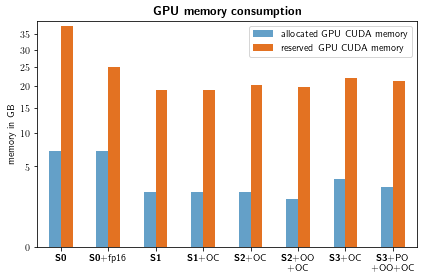

In [16]:
cuda_memory.compare_plot(
    xticks=formatted_run_names_2, 
    figsize=(6, 4), 
    title=r"\textbf{GPU memory consumption}",
    save=True,
    save_dir="../outputs/gemnet/s2ef/cuda_memory"
)